**SINIFLANDIRMA**

frog_data.mat veri seti

Kurbağaların türlerini ses frekansları ile tespit etme.


In [ ]:
# kutuphaneleri import etme
import scipy.io
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score

In [ ]:
# mat dosyasını yukleme
from scipy.io import loadmat

mat = loadmat("/content/frog_data.mat")
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'feat', 'lbl'])


In [ ]:
for k, v in mat.items():
    if not k.startswith("__"):
        print(f"{k}: type={type(v)}, shape={v.shape}")


feat: type=<class 'numpy.ndarray'>, shape=(7195, 22)
lbl: type=<class 'numpy.ndarray'>, shape=(1, 7195)


**feat için : 7195 ÖRNEK --------22 SAYISAL ÖZELLİK (SÜTUN)**


**lbl için : HER ÖRNEK İÇİN 1 SINIF ETİKETİ (TRANPOZ EDİLMELİ)**

In [ ]:
#transpoz y için
import numpy as np

X = mat["feat"]
y = mat["lbl"].ravel()  # (1,7195) → (7195,)


In [ ]:
# x için boş veri kontrolü
np.isnan(X).sum().sum()

np.int64(0)

In [ ]:
# sonsuz deger kontrolu
np.isinf(X).sum().sum()

np.int64(0)

In [ ]:
# y için boş veri kontrolü
np.isnan(y).sum()

np.int64(0)

boş ve sonsuz olan değerler yok


In [ ]:
# Sayısal dağılım
class_counts = pd.Series(y).value_counts().sort_index()
class_counts

,count
0,672
1,542
2,3478
3,310
4,472
5,1121
6,270
7,114
8,68
9,148


In [ ]:
# yüzdelik dağılım
class_percent = class_counts / class_counts.sum() * 100
class_percent

,count
0,9.339819
1,7.533009
2,48.339124
3,4.308548
4,6.560111
5,15.580264
6,3.752606
7,1.584434
8,0.945101
9,2.056984


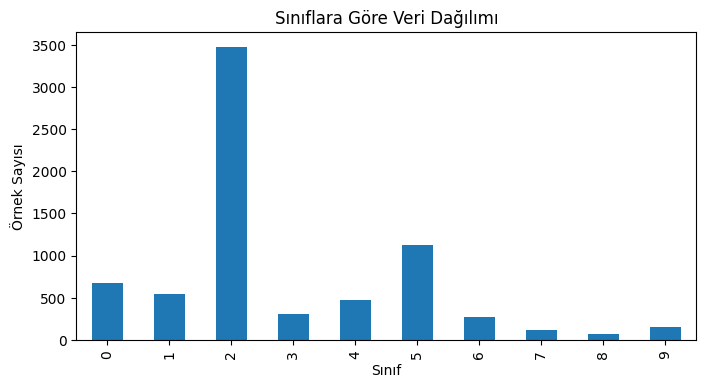

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
class_counts.plot(kind="bar")
plt.xlabel("Sınıf")
plt.ylabel("Örnek Sayısı")
plt.title("Sınıflara Göre Veri Dağılımı")
plt.show()

Veri dengesizliği mevcut, accuracy guvenilir olmaz , macro fskor uygulanmalı

In [ ]:
df = pd.DataFrame(X, columns=[f"feat_{i}" for i in range(X.shape[1])])
df.dtypes


,0
feat_0,float64
feat_1,float64
feat_2,float64
feat_3,float64
feat_4,float64
feat_5,float64
feat_6,float64
feat_7,float64
feat_8,float64
feat_9,float64


In [ ]:
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.156436,0.082245,0.135752,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.254341,0.022786,0.163320,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.237384,0.050791,0.207338,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.317084,-0.011567,0.100413,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.298524,0.037439,0.219153,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244


In [ ]:
# Özelliklerin istatistiksel özeti
print(df.describe().T)

          count      mean       std       min       25%       50%       75%  \
feat_0   7195.0  0.989885  0.069016 -0.251179  1.000000  1.000000  1.000000   
feat_1   7195.0  0.323584  0.218653 -0.673025  0.165945  0.302184  0.466566   
feat_2   7195.0  0.311224  0.263527 -0.436028  0.138445  0.274626  0.430695   
feat_3   7195.0  0.445997  0.160328 -0.472676  0.336737  0.481463  0.559861   
feat_4   7195.0  0.127046  0.162722 -0.636012  0.051717  0.161361  0.222592   
feat_5   7195.0  0.097939  0.120412 -0.410417  0.012581  0.072079  0.175957   
feat_6   7195.0 -0.001397  0.171404 -0.538982 -0.125737 -0.052630  0.085580   
feat_7   7195.0 -0.000370  0.116302 -0.576506 -0.063109  0.013265  0.075108   
feat_8   7195.0  0.128213  0.179008 -0.587313  0.004648  0.189317  0.265395   
feat_9   7195.0  0.055998  0.127099 -0.952266 -0.001132  0.063478  0.117725   
feat_10  7195.0 -0.115682  0.186792 -0.901989 -0.269860 -0.153322  0.026689   
feat_11  7195.0  0.043371  0.155983 -0.799441 -0.033

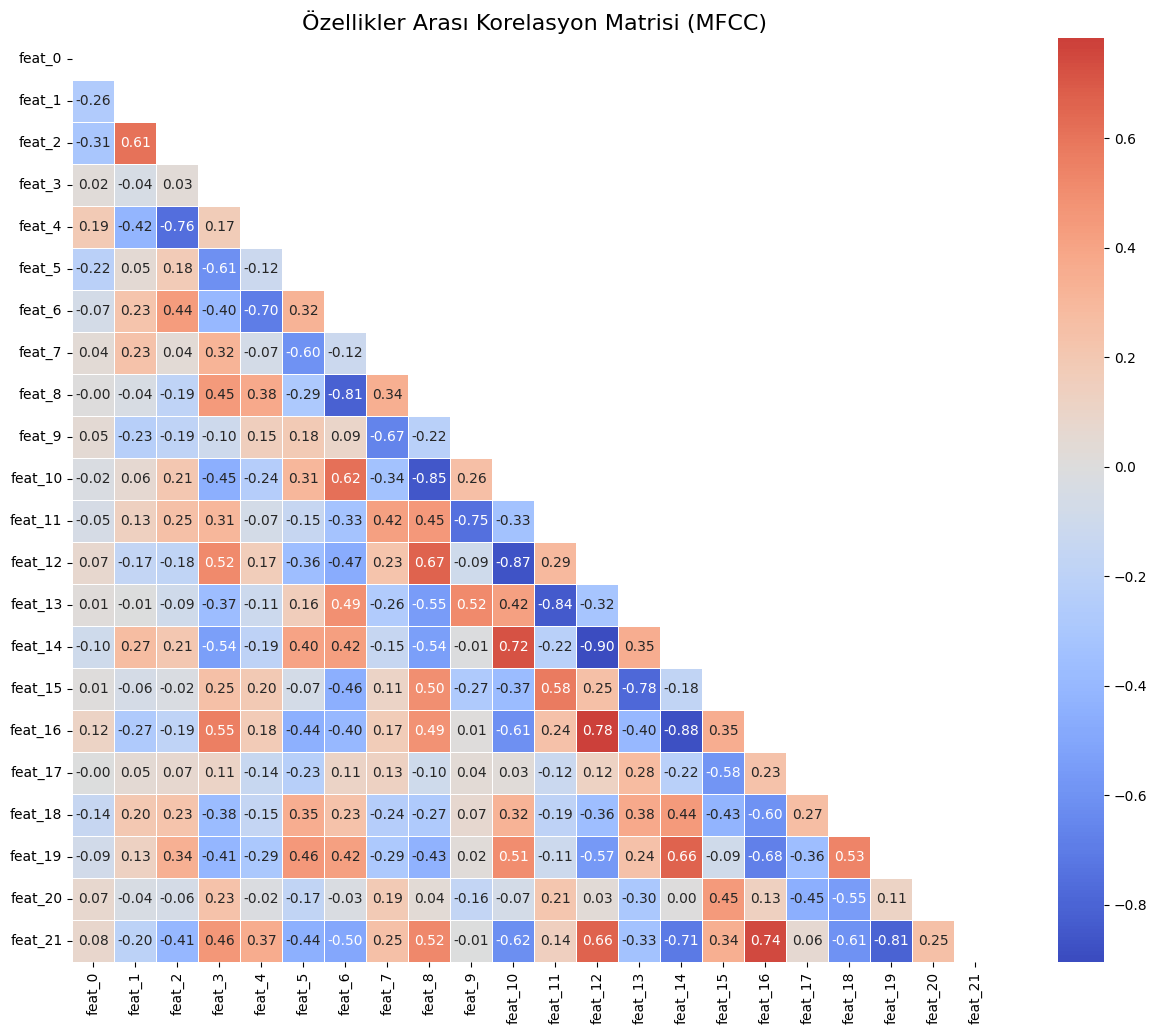

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Korelasyon matrisini hesapla
corr_matrix = df.corr()

# Maske oluştur (Matrisin üst yarısını gizlemek için)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(16, 12))
# Heatmap çizimi
sns.heatmap(corr_matrix,
            mask=mask,
            annot=True,      # Değerleri kutu içine yaz
            fmt=".2f",       # Virgülden sonra 2 basamak
            cmap='coolwarm', # Kırmızı (Pozitif) - Mavi (Negatif)
            center=0,        # 0 noktası beyaz olsun
            linewidths=0.5,
            square=True)

plt.title("Özellikler Arası Korelasyon Matrisi (MFCC)", fontsize=16)
plt.show()




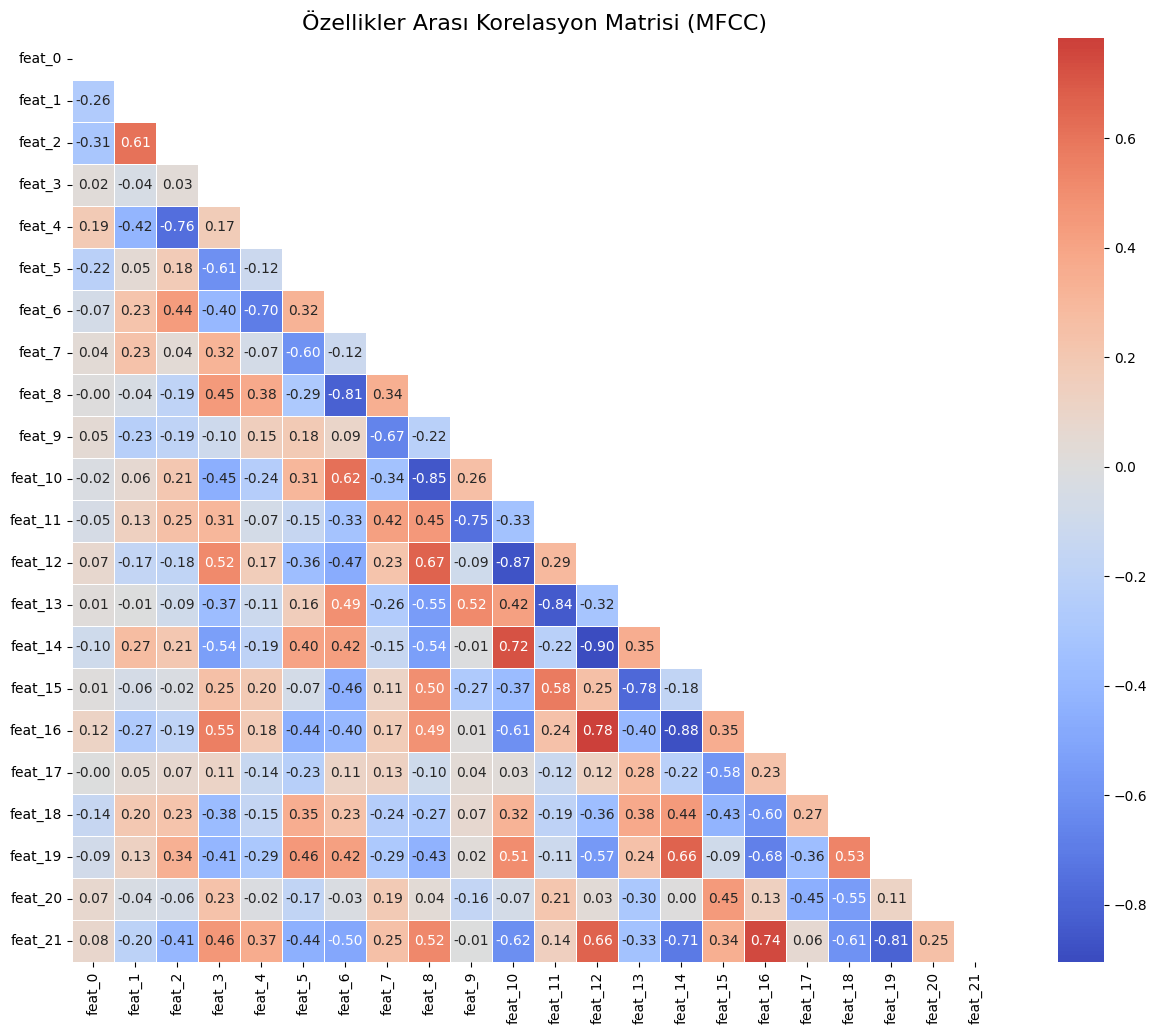

Yüksek Korelasyonlu Özellik Çiftleri:
    level_0  level_1         0
7    feat_6   feat_8 -0.812516
9    feat_8   feat_6 -0.812516
11   feat_8  feat_10 -0.852813
13  feat_10   feat_8 -0.852813
15  feat_10  feat_12 -0.865994
17  feat_11  feat_13 -0.843506
18  feat_12  feat_10 -0.865994
20  feat_12  feat_14 -0.904577
21  feat_13  feat_11 -0.843506
23  feat_14  feat_12 -0.904577
25  feat_14  feat_16 -0.882813
27  feat_16  feat_14 -0.882813
32  feat_19  feat_21 -0.807931
34  feat_21  feat_19 -0.807931


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Korelasyon matrisini hesapla
corr_matrix = df.corr()

# Maske oluştur (Matrisin üst yarısını gizlemek için)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(16, 12))
# Heatmap çizimi
sns.heatmap(corr_matrix,
            mask=mask,
            annot=True,      # Değerleri kutu içine yaz
            fmt=".2f",       # Virgülden sonra 2 basamak
            cmap='coolwarm', # Kırmızı (Pozitif) - Mavi (Negatif)
            center=0,        # 0 noktası beyaz olsun
            linewidths=0.5,
            square=True)

plt.title("Özellikler Arası Korelasyon Matrisi (MFCC)", fontsize=16)
plt.show()


# Sadece yüksek korelasyonlu (pozitif veya negatif) ilişkileri görmek için:
high_corr = corr_matrix[abs(corr_matrix) > 0.8].stack().reset_index()
high_corr = high_corr[high_corr['level_0'] != high_corr['level_1']]
print("Yüksek Korelasyonlu Özellik Çiftleri:")
print(high_corr)

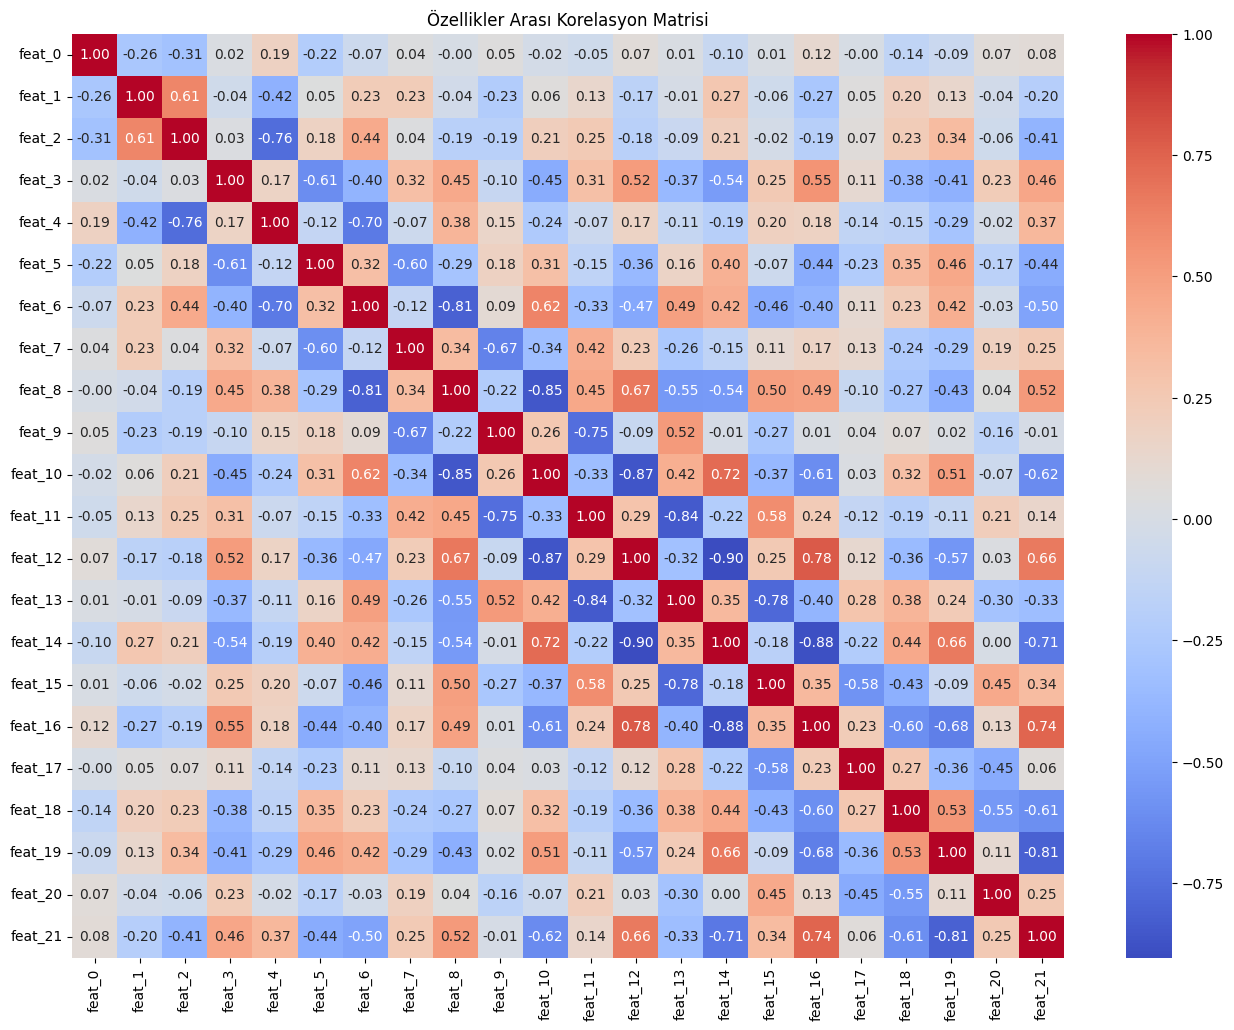

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))
# Özellikler arası korelasyon
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Özellikler Arası Korelasyon Matrisi")
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


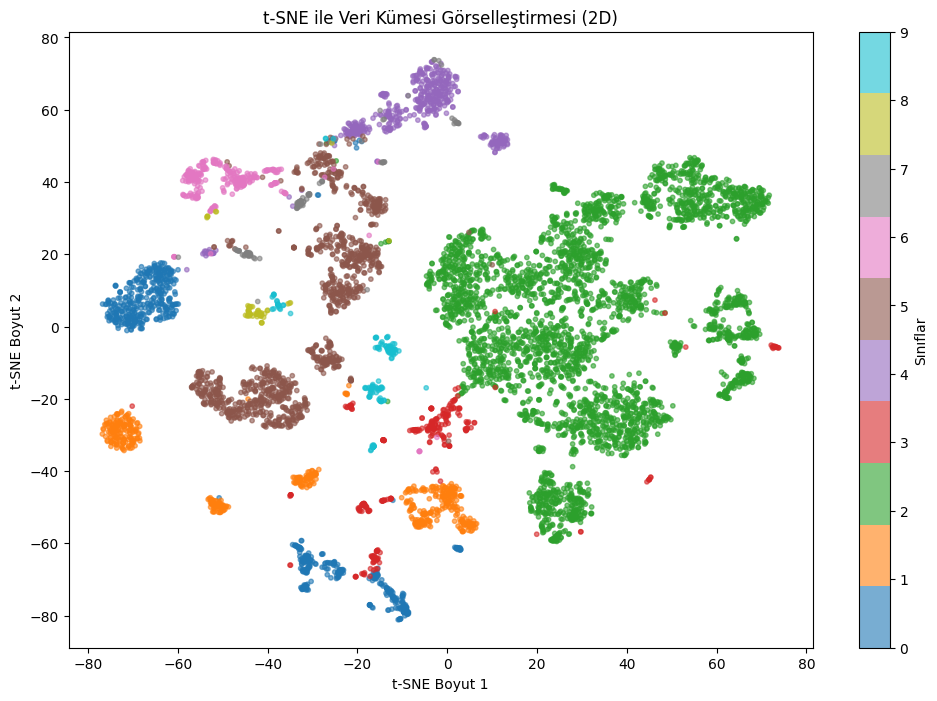

In [ ]:
from sklearn.manifold import TSNE

# Bu işlem veri boyutuna göre biraz zaman alabilir
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='tab10', alpha=0.6, s=10)
plt.colorbar(scatter, label="Sınıflar")
plt.title("t-SNE ile Veri Kümesi Görselleştirmesi (2D)")
plt.xlabel("t-SNE Boyut 1")
plt.ylabel("t-SNE Boyut 2")
plt.show()

**AYKIRI DEGER ANALİZİ YAPMADIM**

veri seti kurbaga ses grekansı veri seti oldugu icin herhangi bir kurabaga turunun sesi tiz vb olabilir veri kaybı olmaması amacıyla yapılmadı


----------------------------------------------------------------------------


RobustScaler Kullanımı: Kodda StandardScaler yerine RobustScaler seçtik.

Farkı şudur: StandardScaler ortalamayı kullanır ve aykırı değerlerden çok etkilenir.

RobustScaler ise Medyan ve IQR (çeyreklikler) üzerinden ölçekleme yapar. Yani aykırı değerler olsa bile, onları silmek yerine etkilerini minimize ederek modeli bunlara karşı dirençli hale getirir.

VM Algoritmasının Gücü

Kullandığımız SVM (C=100) parametresi aslında aykırı değer yönetimiyle doğrudan ilgilidir:


 C Parametresi: "Yumuşak Marjin" (Soft Margin) dengesini ayarlar. Biz yüksek bir C seçtik çünkü verinin t-SNE görselleştirmesinde ve istatistiklerinde gördüğümüz kadarıyla veri oldukça "temiz" ve sınıflar MFCC uzayında iyi ayrışıyor.

In [ ]:
# ----------SVM-------------

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# 1. Veriyi Ayırma (Notebook'undaki X ve y değişkenlerini kullanıyoruz)
# Stratify=y kullanarak her sınıftan dengeli örnek alıyoruz
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Ölçeklendirme (Zaten RobustScaler import etmiştin)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. SVM Parametre Optimizasyonu
# MFCC verilerinde RBF kernel genellikle en iyi sonucu verir.
param_grid = {
    'C': [0.1, 1, 10, 100],        # Hata payı (Regularization)
    'gamma': ['scale', 'auto', 0.1, 0.01], # Karar sınırının esnekliği
    'kernel': ['rbf']
}

# Parametre arama işlemi
# cv=5 ve scoring='f1_macro' senin veri setin için en doğru tercihlerdir.
grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=3, scoring='f1_macro', verbose=1)
#grid.fit(X_train_scaled, y_train.values.ravel())
grid.fit(X_train_scaled, y_train.ravel())
print(f"En iyi Parametreler: {grid.best_params_}")

# 4. Sonuçları Değerlendirme
y_pred_svm = grid.predict(X_test_scaled)
print("\n--- Model Performans Raporu ---")
print(classification_report(y_test, y_pred_svm))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
En iyi Parametreler: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

--- Model Performans Raporu ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       134
           1       1.00      1.00      1.00       108
           2       1.00      1.00      1.00       696
           3       0.98      0.98      0.98        62
           4       0.97      0.97      0.97        94
           5       0.99      1.00      0.99       224
           6       0.98      0.93      0.95        54
           7       0.88      0.91      0.89        23
           8       1.00      0.86      0.92        14
           9       0.94      1.00      0.97        30

    accuracy                           0.99      1439
   macro avg       0.97      0.96      0.97      1439
weighted avg       0.99      0.99      0.99      1439



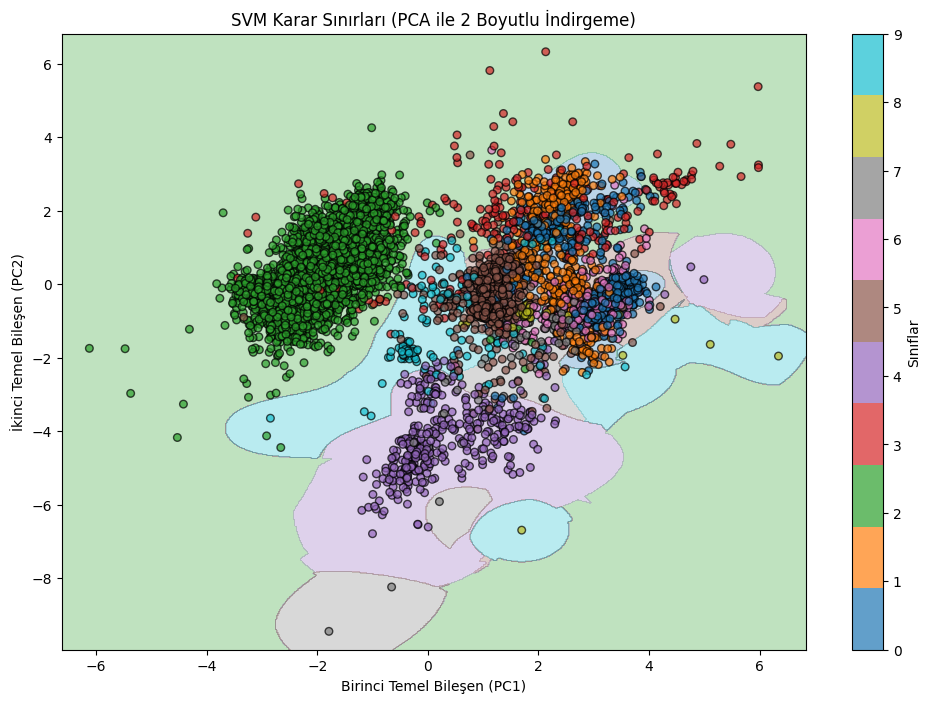

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# 1. Veriyi Görselleştirmek için 2 Boyuta İndirgeyelim (PCA)
# Çünkü 22 boyutta bir grafik çizemeyiz.
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train_scaled)

# 2. Modelimizi sadece bu 2 boyutla tekrar eğitelim (Görselleştirme amaçlı)
# GridSearch'ten bulduğun en iyi parametreleri (C=10, gamma='auto') kullanıyoruz.
svm_model = SVC(kernel='rbf', C=10, gamma='auto', class_weight='balanced')
svm_model.fit(X_reduced, y_train.ravel())

# 3. Grafik için bir ızgara (mesh grid) oluşturalım
h = .02  # Izgara adım boyutu (ne kadar küçükse o kadar detaylı görünür)
x_min, x_max = X_reduced[:, 0].min() - 0.5, X_reduced[:, 0].max() + 0.5
y_min, y_max = X_reduced[:, 1].min() - 0.5, X_reduced[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# 4. Izgaradaki her nokta için tahmin yapalım (Arka plan renkleri için)
Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 5. Görselleştirme
plt.figure(figsize=(12, 8))

# Karar bölgelerini boyayalım
plt.contourf(xx, yy, Z, alpha=0.3, cmap='tab10')

# Gerçek veri noktalarını üzerine ekleyelim
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train,
            edgecolors='k', cmap='tab10', s=30, alpha=0.7)

plt.title("SVM Karar Sınırları (PCA ile 2 Boyutlu İndirgeme)")
plt.xlabel("Birinci Temel Bileşen (PC1)")
plt.ylabel("İkinci Temel Bileşen (PC2)")
plt.colorbar(scatter, label="Sınıflar")
plt.show()

**stratify=y Kullanımı**
sınıf dengesizliği oldugu için


---------------------------------------------------------------------------------------------


**Data Leakage Kaçınıldı**
RobustScaler Kullanımı (Fit vs Transform)

scaler.fit_transform(X_train): Modelin eğitim setindeki değerlerin medyanını ve aralığını öğrendik ve uyguladık.

scaler.transform(X_test): Test setine asla fit yapmadım.

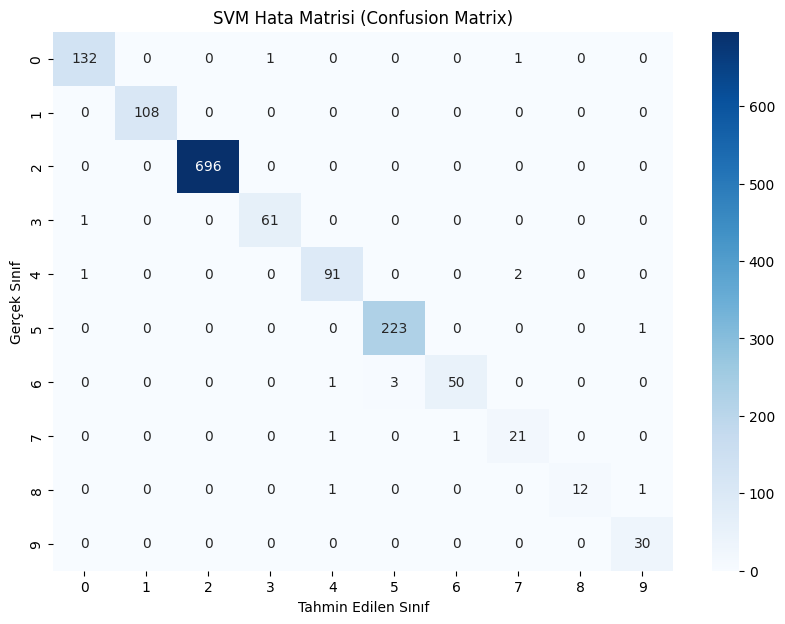

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('SVM Hata Matrisi (Confusion Matrix)')
plt.show()

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils import class_weight

# 1. Sınıf Ağırlıklarını Hesaplama (Dengesizlik için çok kritik)
# Bu işlem, azınlık sınıfların (Sınıf 8 gibi) hatasını modele daha ağır öğretir
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train.ravel())

# --- XGBOOST MODELİ ---
print("XGBoost eğitiliyor...")
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective='multi:softprob',
    random_state=42,
    tree_method='hist' # Daha hızlı eğitim için
)

# Sınıf ağırlıklarını kullanarak eğitiyoruz
xgb_model.fit(X_train_scaled, y_train.ravel(), sample_weight=weights)
y_pred_xgb = xgb_model.predict(X_test_scaled)

# --- LIGHTGBM MODELİ ---
print("LightGBM eğitiliyor...")
lgbm_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    class_weight='balanced', # Dahili dengesi varn
    random_state=42,
    verbose=-1
)

lgbm_model.fit(X_train_scaled, y_train.ravel())
y_pred_lgbm = lgbm_model.predict(X_test_scaled)

# 3. Sonuçların Karşılaştırılması
def print_results(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"\n--- {name} Sonuçları ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1-Score: {f1:.4f}")
    print(classification_report(y_true, y_pred))

print_results("XGBoost", y_test, y_pred_xgb)
print_results("LightGBM", y_test, y_pred_lgbm)

XGBoost eğitiliyor...
LightGBM eğitiliyor...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- XGBoost Sonuçları ---
Accuracy: 0.9826
Macro F1-Score: 0.9555
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       134
           1       0.98      0.98      0.98       108
           2       1.00      1.00      1.00       696
           3       0.98      0.94      0.96        62
           4       0.97      0.98      0.97        94
           5       0.98      0.98      0.98       224
           6       0.93      0.96      0.95        54
           7       0.87      0.87      0.87        23
           8       1.00      0.86      0.92        14
           9       0.91      1.00      0.95        30

    accuracy                           0.98      1439
   macro avg       0.96      0.95      0.96      1439
weighted avg       0.98      0.98      0.98      1439


--- LightGBM Sonuçları ---
Accuracy: 0.9875
Macro F1-Score: 0.9624
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       1

Metrik	         |      SVM	|   XGBoost	|  LightGBM

Macro F1-Score|	 %0.97| %0.95	  |%0.96

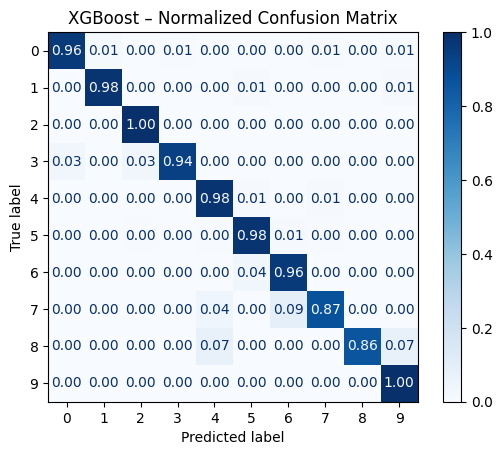

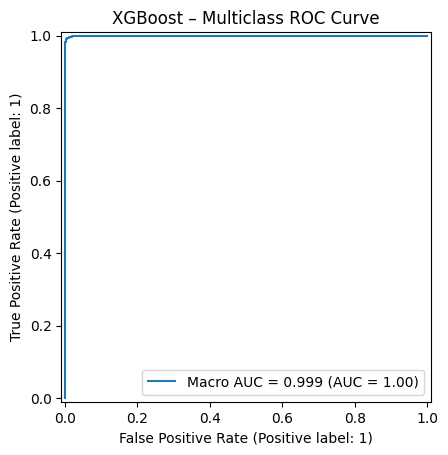

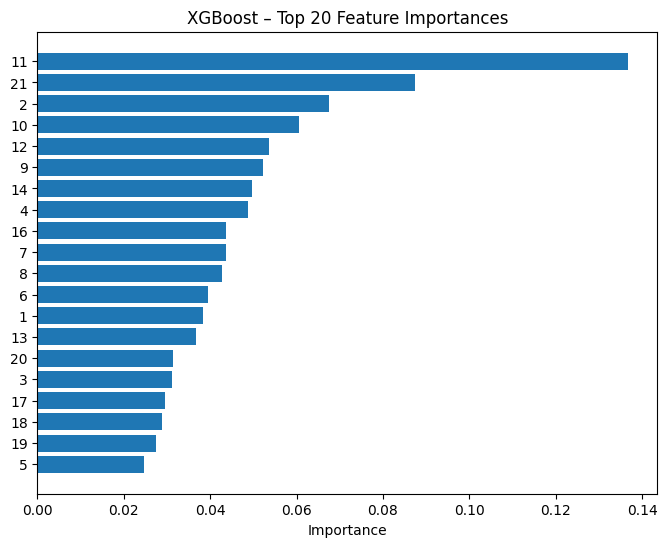

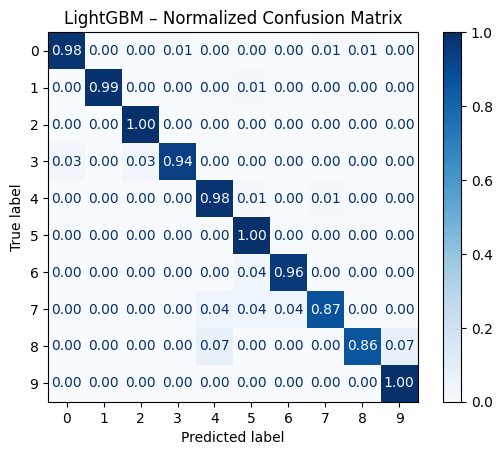

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


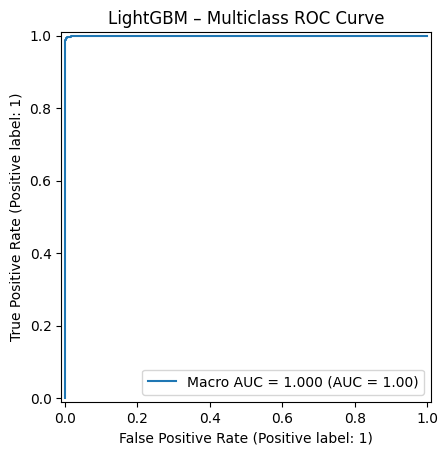

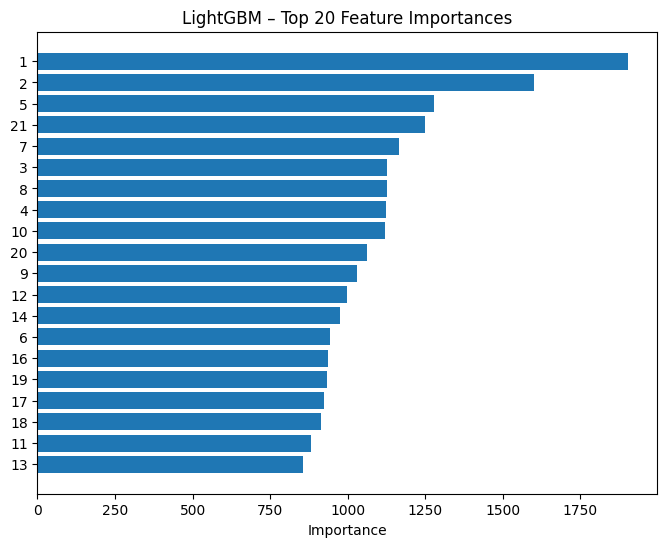

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize



def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format=".2f")
    plt.title(title)
    plt.show()


def plot_multiclass_roc(model, X_test, y_test, title):
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)

    y_proba = model.predict_proba(X_test)
    roc_auc = roc_auc_score(
        y_test_bin, y_proba, multi_class="ovr", average="macro"
    )

    RocCurveDisplay.from_predictions(
        y_test_bin.ravel(),
        y_proba.ravel(),
        name=f"Macro AUC = {roc_auc:.3f}"
    )
    plt.title(title)
    plt.show()


def plot_feature_importance(model, model_name, max_features=20):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-max_features:]

    plt.figure(figsize=(8, 6))
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), indices)
    plt.xlabel("Importance")
    plt.title(f"{model_name} – Top {max_features} Feature Importances")
    plt.show()
# Confusion Matrix
plot_confusion(
    y_test,
    y_pred_xgb,
    title="XGBoost – Normalized Confusion Matrix"
)

# ROC–AUC
plot_multiclass_roc(
    xgb_model,
    X_test_scaled,
    y_test,
    title="XGBoost – Multiclass ROC Curve"
)

# Feature Importance
plot_feature_importance(
    xgb_model,
    "XGBoost"
)
# Confusion Matrix
plot_confusion(
    y_test,
    y_pred_lgbm,
    title="LightGBM – Normalized Confusion Matrix"
)

# ROC–AUC
plot_multiclass_roc(
    lgbm_model,
    X_test_scaled,
    y_test,
    title="LightGBM – Multiclass ROC Curve"
)

# Feature Importance
plot_feature_importance(
    lgbm_model,
    "LightGBM"
)

**Aykırı Deger**


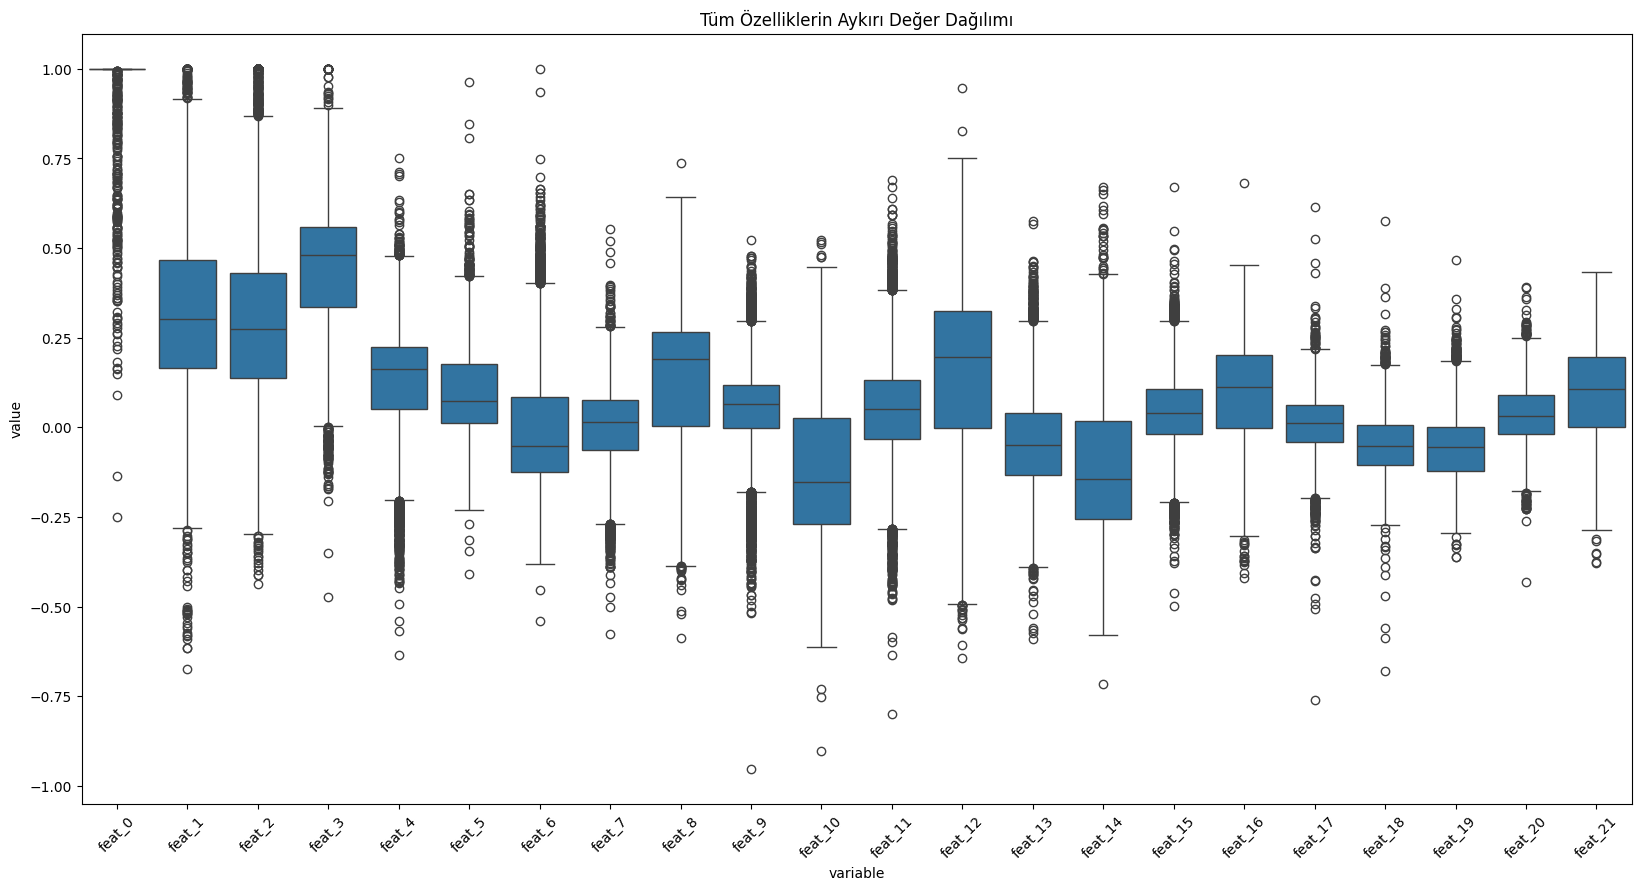

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
# Veriyi görselleştirme için uzun formata getiriyoruz
df_melted = pd.melt(df)
sns.boxplot(x='variable', y='value', data=df_melted)
plt.xticks(rotation=45)
plt.title("Tüm Özelliklerin Aykırı Değer Dağılımı")
plt.show()

In [ ]:
from scipy import stats

# Z-skoru hesaplama
z_scores = np.abs(stats.zscore(df))
# Z-skoru 3'ten büyük olan satırları bulma
outliers = np.where(z_scores > 3)

print(f"Toplam tespit edilen aykırı değer noktası: {len(outliers[0])}")
print(f"En az bir aykırı değere sahip satır sayısı: {len(np.unique(outliers[0]))}")

Toplam tespit edilen aykırı değer noktası: 916
En az bir aykırı değere sahip satır sayısı: 527


In [ ]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42) # Verinin %5'i aykırı varsayalım
y_outliers = iso.fit_predict(df)

# -1 olanlar aykırı, 1 olanlar normaldir
print(f"Isolation Forest tarafından saptanan aykırı satır sayısı: {list(y_outliers).count(-1)}")

Isolation Forest tarafından saptanan aykırı satır sayısı: 360


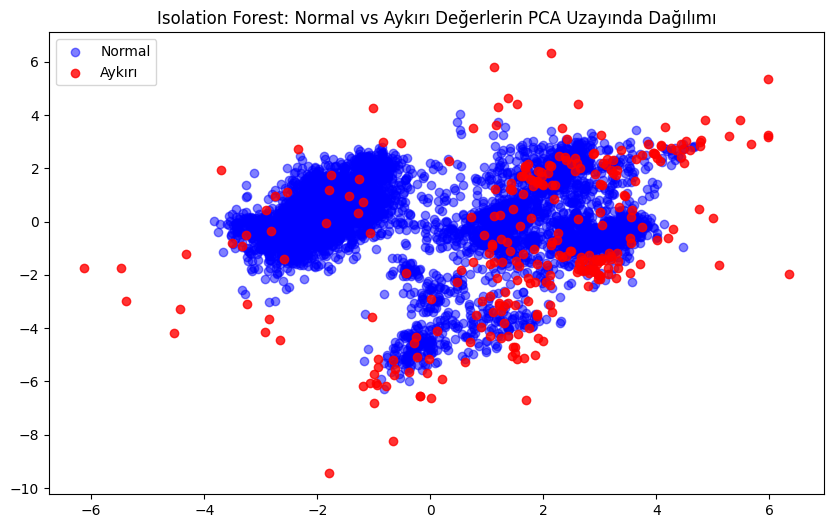

In [ ]:
from sklearn.decomposition import PCA

# Veriyi 2 boyuta indirgeyelim (Görselleştirmek için)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Isolation Forest tahmini (Eğitim seti üzerinde)
iso = IsolationForest(contamination=0.05, random_state=42)
outlier_preds = iso.fit_predict(X_train_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[outlier_preds == 1, 0], X_pca[outlier_preds == 1, 1], c='blue', label='Normal', alpha=0.5)
plt.scatter(X_pca[outlier_preds == -1, 0], X_pca[outlier_preds == -1, 1], c='red', label='Aykırı', alpha=0.8)
plt.legend()
plt.title("Isolation Forest: Normal vs Aykırı Değerlerin PCA Uzayında Dağılımı")
plt.show()

Verimizdeki aykırı değerleri tespit ettik (kırmızı noktalar). Ancak bu değerler veriden kopuk 'bozuk' veriler değil, veri bulutunun uç sınırlarıdır. Bu yüzden onları silmek yerine, RobustScaler ve SVM kullanarak bu sınırları da kapsayacak şekilde modelimizi eğittik.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error
import pandas as pd

# SMAPE Fonksiyonu
def calculate_smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-10))

# Modelleri ve tahminlerini bir listede toplayalım
models = {
    "SVM": y_pred_svm,
    "XGBoost": y_pred_xgb,
    "LightGBM": y_pred_lgbm
}

results = []

for name, pred in models.items():
    results.append({
        "Model": name,
        "ACC (Accuracy)": accuracy_score(y_test, pred),
        "F-Score (Macro)": f1_score(y_test, pred, average='macro'),
        "MAE": mean_absolute_error(y_test, pred),
        "SMAPE (%)": calculate_smape(y_test, pred)
    })

# Sonuçları tabloya dönüştürelim
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

   Model  ACC (Accuracy)  F-Score (Macro)      MAE  SMAPE (%)
     SVM        0.989576         0.966496 0.028492  21.439781
 XGBoost        0.982627         0.955548 0.045170   1.548189
LightGBM        0.987491         0.962366 0.033356  28.268336


10-Fold Cross-Validation çalışıyor, lütfen bekleyiniz...
------------------------------
Her bir Fold (Katman) Başarısı:
[0.99305556 0.98611111 0.98611111 0.99166667 0.98472222 0.9930459
 0.99165508 0.99582754 0.99443672 0.99165508]
------------------------------
Ortalama Başarı (Mean Accuracy): %99.08
Standart Sapma (Standard Deviation): +/- %0.36


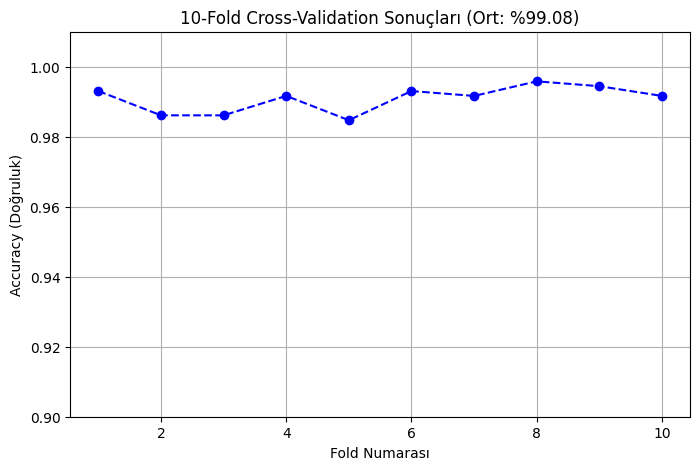

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC

# 1. Pipeline Oluşturma (Scaler + Model)
# Pipeline, her fold işleminde veriyi o an fit edip dönüştürür, sızıntıyı önler.
pipeline = Pipeline([
    ('scaler', RobustScaler()),  # Önce ölçekle
    ('classifier', SVC(kernel='rbf', C=100, gamma=0.1)) # En iyi parametrelerin
])

# 2. 10-Katlı Stratified Cross Validation Ayarı
# Stratified olması, her parçada sınıf oranlarının (türlerin dağılımının) korunmasını sağlar.
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 3. İşlemi Başlatma (Bu işlem biraz zaman alabilir)
print("10-Fold Cross-Validation çalışıyor, lütfen bekleyiniz...")
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

# 4. Sonuçları Raporlama
print("-" * 30)
print("Her bir Fold (Katman) Başarısı:")
print(scores)
print("-" * 30)
print(f"Ortalama Başarı (Mean Accuracy): %{scores.mean()*100:.2f}")
print(f"Standart Sapma (Standard Deviation): +/- %{scores.std()*100:.2f}")

# 5. Sonuçların Görselleştirilmesi (Opsiyonel ama şık durur)
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), scores, marker='o', linestyle='--', color='b')
plt.title(f'10-Fold Cross-Validation Sonuçları (Ort: %{scores.mean()*100:.2f})')
plt.xlabel('Fold Numarası')
plt.ylabel('Accuracy (Doğruluk)')
plt.ylim(0.90, 1.01) # Y eksenini başarıya odaklayalım
plt.grid(True)
plt.show()